In [1]:
from apiclient.discovery import build
from apiclient.errors import HttpError
from oauth2client.tools import argparser
import os
import json
import pandas as pd
import datetime
from dateutil.parser import parse
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [2]:
YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"
DEVELOPER_KEY = os.environ['YOUTUBE_API_KEY']

def initial_api():
    return build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION,
        developerKey=DEVELOPER_KEY)


def channels_list_by_username(service, maxResults=50, part=None, forUsername=None):
    results = service.channels().list(
        part=part,
        maxResults=maxResults,
        forUsername=forUsername
    ).execute()
    
    return results


def playlist_items_list_by_playlist_id(service, part=None, playlistId=None):
    total_results = []
    nextPageToken = ''
    while 1:
        results = service.playlistItems().list(
            part=part,
            maxResults=50,
            playlistId=playlistId,
            pageToken=nextPageToken
        ).execute()
        total_results.extend(results['items'])
        print "got",len(total_results),"results"
        if 'nextPageToken' not in results:
            break
        nextPageToken = results['nextPageToken']

    return total_results


In [3]:
service = initial_api()

In [4]:
%%notify
# get playlist ID of TED uploads
channels = channels_list_by_username(service,
                                     part='contentDetails',
                                     forUsername='TEDtalksDirector')
uploads_playlist_id = channels['items'][0]['contentDetails']['relatedPlaylists']['uploads']

# get list of videos in playlist
playlist_data = playlist_items_list_by_playlist_id(service,
                                                   part='snippet,contentDetails',
                                                   playlistId=uploads_playlist_id)

got 50 results
got 100 results
got 150 results
got 200 results
got 250 results
got 300 results
got 350 results
got 400 results
got 450 results
got 500 results
got 550 results
got 600 results
got 650 results
got 700 results
got 750 results
got 800 results
got 850 results
got 900 results
got 950 results
got 1000 results
got 1050 results
got 1100 results
got 1150 results
got 1200 results
got 1250 results
got 1300 results
got 1350 results
got 1400 results
got 1450 results
got 1500 results
got 1550 results
got 1600 results
got 1650 results
got 1700 results
got 1750 results
got 1800 results
got 1850 results
got 1900 results
got 1950 results
got 2000 results
got 2050 results
got 2100 results
got 2150 results
got 2200 results
got 2250 results
got 2300 results
got 2350 results
got 2400 results
got 2450 results
got 2479 results


<IPython.core.display.Javascript object>

In [5]:
def videos_list_by_id(service, part=None, id=None):
    results = service.videos().list(
        part=part,
        id=id
    ).execute()
    return results 
    

def urls_from_playlist_items(playlist_data):
    results = []
    for video in playlist_data:
        results.append(video['contentDetails']['videoId'])
    return results


# build dataframe of useful information from videos
# columns = url ID, length, views, likes, dislikes, upload date, language, has captions
def df_from_urls(video_urls):
    info_dict = {}
    info_dict['url'] = []
    info_dict['upload_date'] = []
    info_dict['length'] = []
    info_dict['views'] = []
    
    for index, url in enumerate(video_urls):
#        if index >100:
#            continue
        print "getting url " + url + ", #" + str(index) + " out of " + str(len(video_urls))
        data = videos_list_by_id(service,
                               part='snippet,contentDetails,statistics',
                               id=url)
        entry = data['items'][0]
        #print json.dumps(entry, indent=4)
        
        # ignore foreign language talks
#        if 'defaultAudioLanguage' not in entry['snippet'] and 'defaultLanguage' not in entry['snippet']:
        if 'defaultAudioLanguage' not in entry['snippet']:
            print "no language info"
            continue
        #if 'defaultAudioLanguage' in entry['snippet'] and entry['snippet']['defaultAudioLanguage'] != 'en':
        if entry['snippet']['defaultAudioLanguage'] != 'en':
            print "foreign defaultAudioLanguage:", entry['snippet']['defaultAudioLanguage']
            continue
#        elif 'defaultLanguage' in entry['snippet'] and entry['snippet']['defaultLanguage'] != 'en':
#            print "foreign defaultLanguage:", entry['snippet']['defaultLanguage']
#            continue

        # ignore talks missing captions
        if not entry['contentDetails']['caption']:
            print "no captions"
            continue
        
        info_dict['url'].append(url)
        views = int(entry['statistics']['viewCount'])
        info_dict['views'].append(views)
        date = parse(entry['snippet']['publishedAt'])
        info_dict['upload_date'].append(date)
        length = ''
        try:
            length = datetime.datetime.strptime(entry['contentDetails']['duration'], 'PT%MM%SS')
        except:
            pass
        try:
            length = datetime.datetime.strptime(entry['contentDetails']['duration'], 'PT%MM')
        except:
            pass
        if length:
            info_dict['length'].append((length-datetime.datetime(1900,1,1)).total_seconds())
        else:
            info_dict['length'].append(0)
    return pd.DataFrame(info_dict)

In [6]:
%%notify
# get url codes for all videos
video_urls = urls_from_playlist_items(playlist_data)
#video_urls = ['zRvDWVfib2c']
# build dataframe of useful information from videos
# columns = url ID, length, views, likes, dislikes, upload date, language, has captions
video_info_df = df_from_urls(video_urls)
print video_info_df

getting url B5pFS8XD_MM, #0 out of 2479
getting url HXbsVbFAczg, #1 out of 2479
getting url HY71088saG4, #2 out of 2479
getting url eVFYhbHpfqU, #3 out of 2479
getting url hz2ONnzRANs, #4 out of 2479
getting url 0ZfSOArXbGQ, #5 out of 2479
getting url kdqUhTnAgJU, #6 out of 2479
getting url BXcFEhl7ynM, #7 out of 2479
getting url nz0cAjXVepg, #8 out of 2479
getting url a_avBsX60-s, #9 out of 2479
getting url dkmpRQdJslI, #10 out of 2479
getting url Iv3Ud7_hv9g, #11 out of 2479
getting url BPeFy4iyzn0, #12 out of 2479
getting url Urk3xn7l3AM, #13 out of 2479
no language info
getting url u9Lu85L111Y, #14 out of 2479
getting url tb-WdVA4_bo, #15 out of 2479
getting url _2u_eHHzRto, #16 out of 2479
getting url tS2aI-c3Q8A, #17 out of 2479
getting url ptIecdCZ3dg, #18 out of 2479
getting url 9B5Z-7ELMO8, #19 out of 2479
getting url IFjD3NMv6Kw, #20 out of 2479
getting url RlQ3C_VanaU, #21 out of 2479
getting url rThUrXYaneo, #22 out of 2479
getting url c73Q8oQmwzo, #23 out of 2479
getting u

getting url wYC-HKl4RPU, #191 out of 2479
getting url jM9Q3xP2iBo, #192 out of 2479
getting url Fcm-mAwPkxg, #193 out of 2479
getting url -vZXgApsPCQ, #194 out of 2479
getting url 501FEzbB1JI, #195 out of 2479
getting url lwcvhh4pLjE, #196 out of 2479
getting url 3wxBTEo8-T8, #197 out of 2479
getting url qaf-jNLjedo, #198 out of 2479
getting url iWaZEXBbQL0, #199 out of 2479
getting url tbicAmaXYtM, #200 out of 2479
getting url d-8n24ZwZcQ, #201 out of 2479
getting url MEDgtjpycYg, #202 out of 2479
getting url w8lH8tNlAXc, #203 out of 2479
getting url r92jUj7gNRw, #204 out of 2479
getting url ZQElzjCsl9o, #205 out of 2479
getting url hHOX3dlhhZ0, #206 out of 2479
getting url hLltkC-G5dY, #207 out of 2479
getting url RplnSVTzvnU, #208 out of 2479
getting url akOe5-UsQ2o, #209 out of 2479
getting url ZnC_UBmeRxw, #210 out of 2479
getting url 1k89OTpDvIU, #211 out of 2479
getting url D-_Az5nZBBM, #212 out of 2479
getting url XiEQmcZi8cM, #213 out of 2479
getting url uYaF8p_TNSU, #214 out 

getting url y7l5QHRY_AI, #386 out of 2479
getting url wzkFoetp-_M, #387 out of 2479
getting url gVfgkFaswn4, #388 out of 2479
getting url RCXGpEmFbOw, #389 out of 2479
getting url jMVAgCPYYHY, #390 out of 2479
getting url gmj-azFbpkA, #391 out of 2479
getting url R1vskiVDwl4, #392 out of 2479
getting url 6d6oq0zGGmw, #393 out of 2479
getting url KxLMjn4WPBY, #394 out of 2479
getting url a7cDt5r2pGY, #395 out of 2479
getting url WHjKnNbYiOs, #396 out of 2479
getting url 8sheoGMsy3Q, #397 out of 2479
getting url V1ItvwxBENg, #398 out of 2479
getting url zqLYcJ6Ib3c, #399 out of 2479
getting url G8RxjxdUulE, #400 out of 2479
getting url -moW9jvvMr4, #401 out of 2479
getting url k4N2SxUZwiU, #402 out of 2479
getting url vcxwcWuq7KQ, #403 out of 2479
getting url P8GCjrDWWUM, #404 out of 2479
getting url K926HAKRFvw, #405 out of 2479
getting url r_xV-M0KPo0, #406 out of 2479
getting url 96HHmILhyrE, #407 out of 2479
getting url GB4s5b9NL3I, #408 out of 2479
getting url lQflBowgVB4, #409 out 

getting url E7oq6J8HvKw, #581 out of 2479
getting url 0nI65jgHG9o, #582 out of 2479
getting url Fxt_MZKMdes, #583 out of 2479
getting url yXZqYFDFgT8, #584 out of 2479
getting url yBFC-RtfTfg, #585 out of 2479
getting url _MBiP3G2Pzc, #586 out of 2479
getting url Vyn_xLrtZaY, #587 out of 2479
getting url o3VwYIazybI, #588 out of 2479
getting url S8DwxjDrNNM, #589 out of 2479
getting url oYp5XuGYqqY, #590 out of 2479
getting url OAK1UIb-Fio, #591 out of 2479
getting url 6weGCM3sWKc, #592 out of 2479
getting url Xe2nlti47kA, #593 out of 2479
getting url SGG97dDfZ7E, #594 out of 2479
getting url 9uOMectkCCs, #595 out of 2479
getting url y1KIVZw7Jxk, #596 out of 2479
getting url bNpx7gpSqbY, #597 out of 2479
getting url OWq7ToR2U8Q, #598 out of 2479
getting url k8OgHJ4WXR0, #599 out of 2479
getting url 18zvlz5CxPE, #600 out of 2479
getting url yeVz0rtXCmw, #601 out of 2479
getting url 8VwTZFY-fvw, #602 out of 2479
getting url P2AUat93a8Q, #603 out of 2479
getting url VLe84OkwKOA, #604 out 

no language info
getting url 4n8qT0vQbWk, #734 out of 2479
no language info
getting url 9F8-jp_6Uqg, #735 out of 2479
no language info
getting url X4LOF6ftJVU, #736 out of 2479
no language info
getting url Td2hfdXQ5x8, #737 out of 2479
no language info
getting url FFG2rilqT2g, #738 out of 2479
no language info
getting url MbBHVL4hT90, #739 out of 2479
no language info
getting url bArH8r8jJ4g, #740 out of 2479
no language info
getting url kcEIsbO0ivA, #741 out of 2479
no language info
getting url AWPrOvzzqZk, #742 out of 2479
no language info
getting url Qb-D6PTcmfs, #743 out of 2479
no language info
getting url 1bXAkbCyjpo, #744 out of 2479
no language info
getting url dm4fvbrMLPw, #745 out of 2479
no language info
getting url c64M1tZyWPM, #746 out of 2479
no language info
getting url MJK-dMlATmM, #747 out of 2479
no language info
getting url pcSlowAhvUk, #748 out of 2479
no language info
getting url Oj8eFu72_fc, #749 out of 2479
no language info
getting url NXfYNdapq3Q, #750 out of 24

no language info
getting url hgWie9dnssU, #875 out of 2479
no language info
getting url aSL-iIskEFU, #876 out of 2479
no language info
getting url ZdDjexbxVzM, #877 out of 2479
no language info
getting url SCtdx0Xe1GA, #878 out of 2479
no language info
getting url mCZCok_u37w, #879 out of 2479
no language info
getting url CDsNZJTWw0w, #880 out of 2479
no language info
getting url mAvSoNUgMno, #881 out of 2479
no language info
getting url CfqO1U6lfDs, #882 out of 2479
no language info
getting url 7qT3RpaBlJo, #883 out of 2479
no language info
getting url h4mmeN8gv9o, #884 out of 2479
no language info
getting url mArrNRWQEso, #885 out of 2479
no language info
getting url zLNXIXingyU, #886 out of 2479
no language info
getting url LFJ9WAHowcg, #887 out of 2479
no language info
getting url Zo62S0ulqhA, #888 out of 2479
no language info
getting url yVwAodrjZMY, #889 out of 2479
no language info
getting url tzJYY2p0QIc, #890 out of 2479
no language info
getting url uk7gKixqVNU, #891 out of 24

no language info
getting url d6NKdnZvdoo, #1015 out of 2479
no language info
getting url RcGyVTAoXEU, #1016 out of 2479
no language info
getting url B4xOFsygwr4, #1017 out of 2479
no language info
getting url u1K6hnm09xs, #1018 out of 2479
no language info
getting url EXo3qA9V3eI, #1019 out of 2479
no language info
getting url LWULB9Aoopc, #1020 out of 2479
no language info
getting url q43uXdOKPD8, #1021 out of 2479
no language info
getting url Kn5JRgz3W0o, #1022 out of 2479
no language info
getting url jMBdQW2LLxw, #1023 out of 2479
no language info
getting url syjEN3peCJw, #1024 out of 2479
no language info
getting url gIbIewxHQrk, #1025 out of 2479
no language info
getting url N6wjC0sxD2o, #1026 out of 2479
no language info
getting url JTN9Nx8VYtk, #1027 out of 2479
no language info
getting url dIh8KBOOkYU, #1028 out of 2479
no language info
getting url Ht2fzax9wV0, #1029 out of 2479
no language info
getting url SN7wO06Yz1E, #1030 out of 2479
no language info
getting url d0LQCXCiW8g

no language info
getting url xP3-W546HYs, #1152 out of 2479
no language info
getting url Ka70-Hb1wFE, #1153 out of 2479
no language info
getting url oDNgnrt_D8w, #1154 out of 2479
no language info
getting url mAEqvn7B2Qg, #1155 out of 2479
no language info
getting url 7uN4I1wEOXE, #1156 out of 2479
no language info
getting url 6OaIdwUdSxE, #1157 out of 2479
no language info
getting url qtcWebAYmKY, #1158 out of 2479
no language info
getting url VAJ-5J21Rd0, #1159 out of 2479
no language info
getting url Ok6LbV6bqaE, #1160 out of 2479
no language info
getting url v22SdEMzxO4, #1161 out of 2479
no language info
getting url V1yW5IsnSjo, #1162 out of 2479
no language info
getting url GvGAIGbnX7E, #1163 out of 2479
no language info
getting url NhYnouvrG_8, #1164 out of 2479
no language info
getting url k2hQL9Zrokk, #1165 out of 2479
no language info
getting url ueOqYebVhtc, #1166 out of 2479
no language info
getting url Lh9lDWPMWrM, #1167 out of 2479
no language info
getting url KM4Xe6Dlp0Y

no language info
getting url lfBpsV1Hwqs, #1291 out of 2479
no language info
getting url iIwbuS526PI, #1292 out of 2479
no language info
getting url iNDXvJjSniI, #1293 out of 2479
no language info
getting url J8FyHI00ELY, #1294 out of 2479
no language info
getting url PXHczjOg06w, #1295 out of 2479
no language info
getting url f6CILJA110Y, #1296 out of 2479
no language info
getting url jfqwHT3u1-8, #1297 out of 2479
no language info
getting url UoBUXOOdLXY, #1298 out of 2479
no language info
getting url Qzmt2wQMhYo, #1299 out of 2479
no language info
getting url V-WkUKP1l3c, #1300 out of 2479
no language info
getting url xzT6iH2CX4k, #1301 out of 2479
no language info
getting url vwTDeT4v7RM, #1302 out of 2479
no language info
getting url 1L6l-FiV4xo, #1303 out of 2479
no language info
getting url IzPcu0-ETTU, #1304 out of 2479
no language info
getting url nCg2NcGYu34, #1305 out of 2479
no language info
getting url GIbz9ms9Z9k, #1306 out of 2479
no language info
getting url dv3E6ESTp30

no language info
getting url t1Z_oufuQg4, #1428 out of 2479
no language info
getting url Aa2JfigaNcs, #1429 out of 2479
no language info
getting url LMrzdk_YnYY, #1430 out of 2479
no language info
getting url CTEhgUmSrro, #1431 out of 2479
no language info
getting url ttDM6ZtLUL4, #1432 out of 2479
no language info
getting url A-QpKiU-NHo, #1433 out of 2479
no language info
getting url -j2XrT0QN5A, #1434 out of 2479
no language info
getting url 7UOEk-YkxdU, #1435 out of 2479
no language info
getting url 7shXEFuxHAA, #1436 out of 2479
no language info
getting url x4lA-M3zbdU, #1437 out of 2479
no language info
getting url xossR6eHv3I, #1438 out of 2479
no language info
getting url -Ht4qiDRZE8, #1439 out of 2479
no language info
getting url ka8L1YMR88U, #1440 out of 2479
no language info
getting url bTE0MRRXNzs, #1441 out of 2479
no language info
getting url stngBN4hp14, #1442 out of 2479
no language info
getting url cMXFiYhm79g, #1443 out of 2479
no language info
getting url LnQcCgS7aPQ

no language info
getting url zAFcV7zuUDA, #1565 out of 2479
no language info
getting url IDkSDPgrtjs, #1566 out of 2479
no language info
getting url J6--CMhcCfQ, #1567 out of 2479
no language info
getting url oXbhTHaMwTw, #1568 out of 2479
no language info
getting url hupHAPF1fHY, #1569 out of 2479
no language info
getting url 6Waurx8e-1o, #1570 out of 2479
no language info
getting url zw9NXY3xOOI, #1571 out of 2479
no language info
getting url U9cGdRNMdQQ, #1572 out of 2479
no language info
getting url vqqWw3xkMzA, #1573 out of 2479
no language info
getting url Ra-lxoAUP5c, #1574 out of 2479
no language info
getting url eqsXc_aefKI, #1575 out of 2479
no language info
getting url Y350oOiunf4, #1576 out of 2479
no language info
getting url 3p3-vl9VFYU, #1577 out of 2479
no language info
getting url CijsvAGU6-c, #1578 out of 2479
no language info
getting url bKQA6I4BA7o, #1579 out of 2479
no language info
getting url B8ofWFx525s, #1580 out of 2479
no language info
getting url KnCqR2yUXoU

no language info
getting url KyamsZXXF2w, #1702 out of 2479
no language info
getting url ViZBwbzOcC8, #1703 out of 2479
no language info
getting url PxQcnxSbivQ, #1704 out of 2479
no language info
getting url GAMR5RD_LJo, #1705 out of 2479
no language info
getting url z_XchYY3bnU, #1706 out of 2479
no language info
getting url 796LfXwzIUk, #1707 out of 2479
no language info
getting url zjPtuhEJQb4, #1708 out of 2479
no language info
getting url XzNLfw5lS4A, #1709 out of 2479
no language info
getting url fddYApFEWfY, #1710 out of 2479
no language info
getting url bkeBjP_9ZR4, #1711 out of 2479
no language info
getting url Cqj0sgrNL10, #1712 out of 2479
no language info
getting url 3gSSNHO1dDs, #1713 out of 2479
no language info
getting url 3GBrJiSMFu0, #1714 out of 2479
no language info
getting url b98Iw_AeGQg, #1715 out of 2479
no language info
getting url GlUS6KE67Vs, #1716 out of 2479
no language info
getting url AIfwFLDXFyQ, #1717 out of 2479
no language info
getting url PKbet4RdSo4

no language info
getting url cfR6tiSW-AM, #1839 out of 2479
no language info
getting url rNgqQNovWTc, #1840 out of 2479
no language info
getting url LoXAAEy6YQU, #1841 out of 2479
no language info
getting url V-bjOJzB7LY, #1842 out of 2479
no language info
getting url V74AxCqOTvg, #1843 out of 2479
no language info
getting url tWmJcR-x_hc, #1844 out of 2479
no language info
getting url GFivy8eFFBo, #1845 out of 2479
no language info
getting url jZxLsDkvkVQ, #1846 out of 2479
no language info
getting url XkiXXP_hycA, #1847 out of 2479
no language info
getting url B0cphH1jkQI, #1848 out of 2479
no language info
getting url n8eyF4UWG38, #1849 out of 2479
no language info
getting url HUM2rCIUdeI, #1850 out of 2479
no language info
getting url C_SBGTJgBGo, #1851 out of 2479
no language info
getting url MLU7qcMYKO8, #1852 out of 2479
no language info
getting url yyemG7V5ynQ, #1853 out of 2479
no language info
getting url zDcaoTVy4fA, #1854 out of 2479
no language info
getting url Hj9oB4zpHww

no language info
getting url auSFX0o3uFU, #1976 out of 2479
no language info
getting url CGksAjzI0go, #1977 out of 2479
no language info
getting url tpKWHSsBpnE, #1978 out of 2479
no language info
getting url Uwl012o8P7I, #1979 out of 2479
no language info
getting url vlj9aPKB9m0, #1980 out of 2479
no language info
getting url KVhWqwnZ1eM, #1981 out of 2479
no language info
getting url y1GqNN2Xe7g, #1982 out of 2479
no language info
getting url rrkrvAUbU9Y, #1983 out of 2479
no language info
getting url M0yhHKWUa0g, #1984 out of 2479
no language info
getting url pxr2GRJ6tjc, #1985 out of 2479
no language info
getting url WCGuG0uT6ks, #1986 out of 2479
no language info
getting url QOSPNVunyFQ, #1987 out of 2479
no language info
getting url nF_dHdNOgSA, #1988 out of 2479
no language info
getting url k_GFq12w5WU, #1989 out of 2479
no language info
getting url mSHBma0Ithk, #1990 out of 2479
no language info
getting url rXepkIWPhFQ, #1991 out of 2479
no language info
getting url rBKV4rOgSJU

no language info
getting url atn22-bmTPU, #2115 out of 2479
no language info
getting url 2RD0OZCyJCk, #2116 out of 2479
no language info
getting url gK8Yk3mEEb8, #2117 out of 2479
no language info
getting url fXYckRgsdjI, #2118 out of 2479
no language info
getting url 4mNgNV533nk, #2119 out of 2479
no language info
getting url DeyzUysMLy0, #2120 out of 2479
no language info
getting url Ei5oOEoGlIM, #2121 out of 2479
no language info
getting url TgxLl-jBAjY, #2122 out of 2479
no language info
getting url uNYMw9O2bu4, #2123 out of 2479
no language info
getting url LNOtiRB3uyk, #2124 out of 2479
no language info
getting url U6MhV5Rn63M, #2125 out of 2479
no language info
getting url aSNrKS-sCE0, #2126 out of 2479
no language info
getting url NWvXyobH9fg, #2127 out of 2479
no language info
getting url 7_XAMm_TBJk, #2128 out of 2479
no language info
getting url c-4flnuxNV4, #2129 out of 2479
no language info
getting url GQDQ9rUx-6g, #2130 out of 2479
no language info
getting url 3GXlvP4kLHg

no language info
getting url XI5frPV58tY, #2253 out of 2479
no language info
getting url d21Eyvhk9Z4, #2254 out of 2479
no language info
getting url U_ob8SBXF_E, #2255 out of 2479
no language info
getting url _6uKZWnJLCM, #2256 out of 2479
no language info
getting url z_VdcDJAlWQ, #2257 out of 2479
no language info
getting url YtdE662eY_M, #2258 out of 2479
no language info
getting url 8D0pwe4vaQo, #2259 out of 2479
no language info
getting url IN88mI8zpSg, #2260 out of 2479
no language info
getting url NgYE75gkzkM, #2261 out of 2479
no language info
getting url Zj2QoLhfwew, #2262 out of 2479
no language info
getting url VDX3RgokKxU, #2263 out of 2479
no language info
getting url d3xlb6_0OEs, #2264 out of 2479
no language info
getting url B67LTsGENPQ, #2265 out of 2479
no language info
getting url 3qF26MbYgOA, #2266 out of 2479
no language info
getting url VxGMqKCcN6A, #2267 out of 2479
no language info
getting url 640BQNxB5mc, #2268 out of 2479
no language info
getting url wcZFIy2mfyE

no language info
getting url vkA4CkczvqI, #2391 out of 2479
no language info
getting url 7-onVz1D_uc, #2392 out of 2479
no language info
getting url a8nDJaH-fVE, #2393 out of 2479
no language info
getting url RHTTIg7HY80, #2394 out of 2479
no language info
getting url xBIVlM435Zg, #2395 out of 2479
no language info
getting url ipfqKyxm5Hc, #2396 out of 2479
no language info
getting url 7g0O003kufA, #2397 out of 2479
no language info
getting url YqO7VXW3ko8, #2398 out of 2479
no language info
getting url Q1ZeXnmDZMQ, #2399 out of 2479
no language info
getting url Yd9cf_vLviI, #2400 out of 2479
no language info
getting url 5KdOPY1Iqiw, #2401 out of 2479
no language info
getting url 9zcSdv3j7zs, #2402 out of 2479
no language info
getting url vMKNUylmanQ, #2403 out of 2479
no language info
getting url 51z7WRDjOjM, #2404 out of 2479
no language info
getting url 2HgL5OFip-0, #2405 out of 2479
no language info
getting url pANJjkU0Whw, #2406 out of 2479
no language info
getting url 2FSE3TNFkJQ

<IPython.core.display.Javascript object>

In [25]:
# make a copy to mess with
df_filtered = video_info_df
# just take videos from 2015
#df_filtered = df_filtered[df_filtered['upload_date'].apply(lambda row: row.year) == 2016]
# filter out super popular videos
#df_filtered = df_filtered[video_info_df['views'] < 75000]
#df_filtered = df_filtered[video_info_df['views'] < 100000]
# filter out really short and long videos
#df_filtered = df_filtered[video_info_df['length'] > 1200]
#df_filtered = df_filtered[video_info_df['length'] < 600]


# currently getting videos from 2016, length < 10 minutes
# still need 2016 all > 20 minutes
# have all 2016 videos with 10 < length < 20 minutes
# have 2015 and 2016 videos 

#print df_filtered
print len(df_filtered)

613


In [19]:
import matplotlib.pyplot as plt
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams.update({'font.size': 28})

In [20]:
views = df_filtered['views'].tolist()
plot = plt.hist(views, 
                len(views)/10, 
                range=[0, 1000000],                
                histtype='stepfilled',
                stacked=False,
                alpha=0.5,
                #normed=True,
                color = 'c',
                edgecolor = "c",
                linewidth=5)
axes = plt.gca()
#axes.set_ylim(0,10)
#plt.yscale('log')
axes.set_xlabel("Number of Views")
axes.set_ylabel("Frequency")
plt.show()

ValueError: `bins` should be a positive integer.

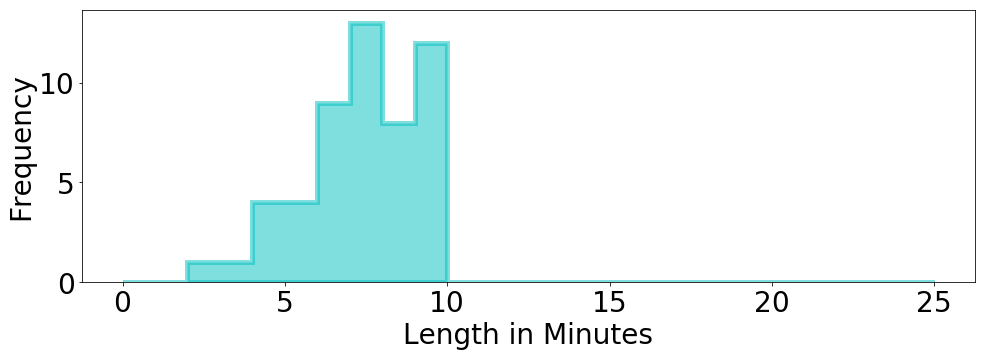

In [12]:
lengths_sec = df_filtered['length'].tolist()
lengths_min = [sec/60. for sec in lengths_sec]
plot = plt.hist(lengths_min, 
                25, 
                range=[0, 25],                
                histtype='stepfilled',
                stacked=False,
                alpha=0.5,
                #normed=True,
                color = 'c',
                edgecolor = "c",
                linewidth=5)
axes = plt.gca()
#axes.set_ylim(0,10)
#plt.yscale('log')
axes.set_xlabel("Length in Minutes")
axes.set_ylabel("Frequency")
plt.show()

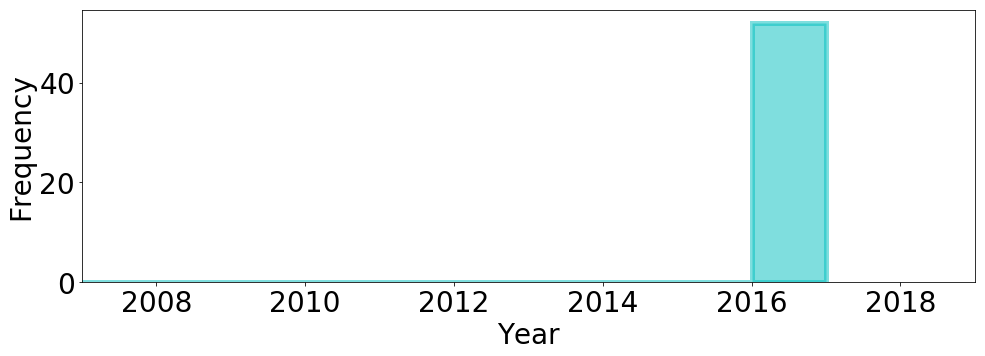

In [13]:
dates = df_filtered['upload_date'].tolist()
years = [date.year for date in dates]
plot = plt.hist(years, 
                10, 
                range=[2007, 2017],                
                histtype='stepfilled',
                stacked=False,
                alpha=0.5,
                #normed=True,
                color = 'c',
                edgecolor = "c",
                linewidth=5)
axes = plt.gca()
axes.set_xlim(2007, 2019)
#plt.yscale('log')
axes.set_xlabel("Year")
axes.set_ylabel("Frequency")
plt.show()


In [22]:
# dataset is ready!  let's save the urls so we can get our scraper running later if need be

urls = df_filtered['url'].tolist()
#urls = ['_MBiP3G2Pzc']
print urls
print len(urls)
with open('urls.json', mode='w') as outputFile:
    json.dump(urls, outputFile, indent=4)

[u'D-_Az5nZBBM', u'o8NPllzkFhE', u'U7y4GlmwPLQ', u'gVfgkFaswn4']
4


In [23]:
%%notify
from __future__ import unicode_literals
import youtube_dl

ydl_opts = {
#    'skip_download': True,
    'writesubtitles' : True,
#    'writeautomaticsub': True,    
    'format': 'bestaudio/best',
    'outtmpl' : '%(id)s.%(ext)s',
    'forcefilename' : True,
    'subtitleslangs' : ['en'],
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'm4a',
    }],
}


with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    for index, url in enumerate(urls):
        print index
#        if index >1:
#            break
        address = 'https://www.youtube.com/watch?v='+url
        ydl.download([address])

0
[youtube] D-_Az5nZBBM: Downloading webpage
[youtube] D-_Az5nZBBM: Downloading video info webpage
[youtube] D-_Az5nZBBM: Extracting video information
[youtube] D-_Az5nZBBM: Downloading MPD manifest
D-_Az5nZBBM.webm
[info] Writing video subtitles to: D-_Az5nZBBM.en.vtt
[download] Destination: D-_Az5nZBBM.webm
[download] 100% of 15.02MiB in 00:0182MiB/s ETA 00:006
[ffmpeg] Destination: D-_Az5nZBBM.m4a
Deleting original file D-_Az5nZBBM.webm (pass -k to keep)
1
[youtube] o8NPllzkFhE: Downloading webpage
[youtube] o8NPllzkFhE: Downloading video info webpage
[youtube] o8NPllzkFhE: Extracting video information
[youtube] o8NPllzkFhE: Downloading MPD manifest
o8NPllzkFhE.webm
[info] Writing video subtitles to: o8NPllzkFhE.en.vtt
[download] Destination: o8NPllzkFhE.webm
[download] 100% of 18.46MiB in 00:0228MiB/s ETA 00:009
[ffmpeg] Destination: o8NPllzkFhE.m4a
Deleting original file o8NPllzkFhE.webm (pass -k to keep)
2
[youtube] U7y4GlmwPLQ: Downloading webpage
[youtube] U7y4GlmwPLQ: Download

gVfgkFaswn4.webm
[download] Destination: gVfgkFaswn4.webm
[download] 100% of 24.58MiB in 00:0282MiB/s ETA 00:006
[ffmpeg] Destination: gVfgkFaswn4.m4a
Deleting original file gVfgkFaswn4.webm (pass -k to keep)


<IPython.core.display.Javascript object>